# Double Deep Q-Network
### Solving `Cartpole_v1` Problem

In [1]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

## DoubleDQN class
The following class contains two networks:
- Main network $Q$: `self.model`,
- Target network $Q'$: `self.target_model`,

where $Q$ network is used for **_action selection_** while $Q'$ network is used for **_action evaluation_**.

The target network is updated at intervals `target_update_frequency` to match with the main Q network.

> **TODO:** Implement Polyak averaging.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, alpha):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.99
        self.epsilon = 0.1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999 
        self.learning_rate = alpha 
        self.train_start = 1000
        self.model = self._build_model()

        # Target model
        self.target_model = self._build_model()
        self.update_target_network()
        self.target_update_frequency = 100
        self.update_counter = 0
        
    def _build_model(self):
        initializer = initializers.GlorotNormal(seed=42)
        model = Sequential([
            Dense(8, input_dim=self.state_size, activation='relu', kernel_initializer=initializer),
            Dense(16, activation='relu', kernel_initializer=initializer),
            Dense(self.action_size, activation='linear', kernel_initializer=initializer)
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return []

        minibatch = random.sample(self.memory, batch_size)
        batch_loss = []

        current_state = np.zeros((batch_size, self.state_size))
        next_state = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(batch_size):
            current_state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # Standard DQN update
        target_q = self.model.predict(current_state, verbose=0)
        next_q_values = self.target_model.predict(next_state, verbose=0)

        for i in range(batch_size):
            if done[i]:
                target_q[i][action[i]] = reward[i]
            else:
                target_q[i][action[i]] = reward[i] + self.gamma * np.max(next_q_values[i])

        self.model.fit(current_state, target_q, batch_size=batch_size, epochs=1, verbose=0)
        batch_loss.append(-0.1) # TODO: extract loos and replace it with -0.1

        if (self.epsilon > self.epsilon_min) and \
             (len(self.memory) >= self.train_start):
                self.epsilon *= self.epsilon_decay

        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_frequency == 0:
            self.update_target_network()

        return batch_loss

Double Deep Q-Network is a modified version of DQN for solving the overestimation problem.

Key Ideas
- Double Q-networks in an embedded manner for target value estimation.
- Change line 14 in DQN Algorithm to be:
    - Set $Y_j = R_j + \gamma (1 − D_j) \hat{Q}(\phi_{j+1}, \text{argmax}_{a^{′}} Q(φ_{j+1}, a^{′}; \theta_j); \hat{\theta})$.

In [ ]:
class DoubleDQN(DQNAgent):
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return []

        minibatch = random.sample(self.memory, batch_size)
        batch_loss = []

        current_state = np.zeros((batch_size, self.state_size))
        next_state = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(batch_size):
            current_state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # Double DQN update
        next_q_values = self.target_model.predict(next_state, verbose=0)
        # TODO: Find a' in DDQN scheme
        target_q = self.model.predict(current_state, verbose=0)

        for i in range(batch_size):
            if done[i]:
                target_q[i][action[i]] = reward[i]
            else:
                target_q[i][action[i]] = reward[i] + self.gamma * 0.00*np.max(next_q_values[i]) # TODO: Modify this to the DDQN update rule.

        hist = self.model.fit(current_state, target_q, batch_size=batch_size, epochs=1, verbose=0)
        batch_loss.append(-0.1) # TODO: extract loos and replace it with -0.1

        if (self.epsilon > self.epsilon_min) and \
             (len(self.memory) >= self.train_start):
                self.epsilon *= self.epsilon_decay

        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_frequency == 0:
            self.update_target_network()

        return batch_loss

> **TODO:** Complete TODO sections in the above cell.

In [5]:
def single_run(alpha=0.01, N=500):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n 
    agent = DoubleDQN(state_size, action_size, alpha)

    episode_lengths = np.zeros(shape=(N,))
    mse_per_episode = np.zeros(shape=(N,))
    scores = []
    
    batch_size = 64
    max_steps = 200
    
    for episode in range(N):
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])        # Reshape state for NN      
        steps = 0
        
        while steps < max_steps:
            # Select and perform action
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])            # Reshape state for NN

            # Modified reward structure
            done = terminated or truncated
            reward = reward if not done else -100 ############### TODO: experiment with and without this modified reward structure
            
            # Store transition
            agent.remember(state, action, reward, next_state, done)
            
            # Move to next state
            state = next_state
            steps += 1
            
            # Perform batch training if enough samples
            if len(agent.memory) > batch_size:
                batch_loss = agent.replay(batch_size)
                # TODO: Log these losses
            
            if done:
                break
        
        # Store episode results
        episode_lengths[episode] = steps
        mse_per_episode[episode] = -0.1 ## TODO: Store and log MSE of the episode
        scores.append(reward)
        
        # Logging
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode + 1:4d} | "
                  f"Score: {steps:4d} | "
                  f"Epsilon: {agent.epsilon:.2f} | "
                  f"Memory: {len(agent.memory):5d} | "
                  f"MSE: {mse_per_episode[episode]:.2f}")

        # TODO: Add convergence criteria

    return agent, scores, episode_lengths, mse_per_episode

# Main

In [ ]:
n_episodes = 30
alph1 = 'lr=0.001'
alph2 = 'lr=0.002'

In [6]:
%%time

model1, reward_hist_tot1, ep_length_tot1, mse_per_episode_tot1 = single_run(alpha=0.001, N=n_episodes)
model2, reward_hist_tot2, ep_length_tot2, mse_per_episode_tot2 = single_run(alpha=0.002, N=n_episodes)

episode: 10, score: 9, e: 0.1, memory length: 101, mse: 4.8e+02
episode: 20, score: 20, e: 0.1, memory length: 278, mse: 3.1e+02
episode: 30, score: 24, e: 0.1, memory length: 538, mse: 2.2e+02
episode: 40, score: 30, e: 0.095, memory length: 1000, mse: 9.7e+01
episode: 50, score: 13, e: 0.077, memory length: 1000, mse: 1.3e+02
episode: 60, score: 137, e: 0.039, memory length: 1000, mse: 7.2e+01
episode: 70, score: 182, e: 0.01, memory length: 1000, mse: 3.2e+01
episode: 80, score: 147, e: 0.01, memory length: 1000, mse: 2.7e+01
episode: 90, score: 87, e: 0.01, memory length: 1000, mse: 7.3
episode: 100, score: 200, e: 0.01, memory length: 1000, mse: 3.5e+01
episode: 110, score: 200, e: 0.01, memory length: 1000, mse: 4.9e+01
episode: 120, score: 200, e: 0.01, memory length: 1000, mse: 2.2e+01
episode: 130, score: 200, e: 0.01, memory length: 1000, mse: 4.3e+01
episode: 140, score: 200, e: 0.01, memory length: 1000, mse: 5.9e+01
Problem is solved in 147 episodes
episode: 10, score: 30,

## Learning curves

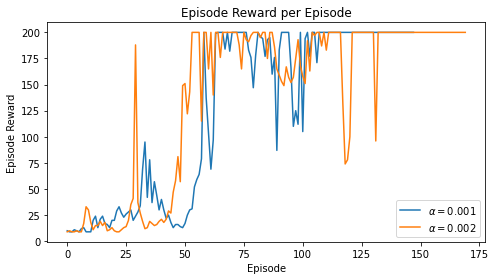

In [7]:
# Episode Reward vs. Episode
plt.figure(figsize=(7, 4))
plt.plot(reward_hist_tot1, label=alph1)
plt.plot(reward_hist_tot2, label=alph2)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('Episode Reward per Episode')
plt.legend()
# plt.grid(True)
# plt.ylim(-200, 15)
plt.tight_layout()
plt.show()

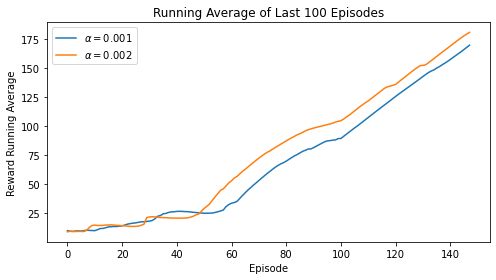

In [9]:
def plot_running_avg(totalrewards1,totalrewards2):
    N = len(totalrewards1)
    totalrewards1 = np.array(totalrewards1)
    totalrewards2 = np.array(totalrewards2)
    running_avg1 = np.empty(N)
    running_avg2 = np.empty(N)
    for t in range(N):
        running_avg1[t] = totalrewards1[max(0, t-100):(t+1)].mean()
        running_avg2[t] = totalrewards2[max(0, t-100):(t+1)].mean()
    plt.figure(figsize=(7, 4))
    plt.plot(running_avg1, label=alph1)
    plt.plot(running_avg2, label=alph2)
    plt.xlabel('Episode')
    plt.ylabel('Reward Running Average')
    plt.title("Running Average of Last 100 Episodes")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_running_avg(reward_hist_tot1,reward_hist_tot2)

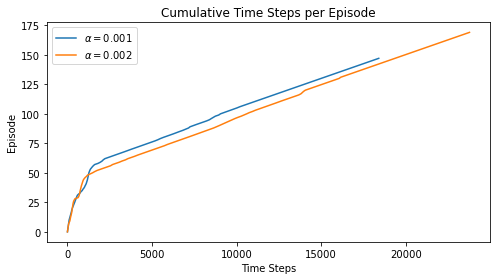

In [10]:
cumulative_steps1 = np.cumsum(ep_length_tot1)
cumulative_steps2 = np.cumsum(ep_length_tot2)

# Cumulative Time Steps vs. Episode
plt.figure(figsize=(7, 4))
plt.plot(cumulative_steps1[0:len(reward_hist_tot1)], range(len(reward_hist_tot1)), label=alph1)
plt.plot(cumulative_steps2[0:len(reward_hist_tot2)], range(len(reward_hist_tot2)), label=alph2)
plt.ylabel('Episode')
plt.xlabel('Time Steps')
plt.title('Cumulative Time Steps per Episode')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

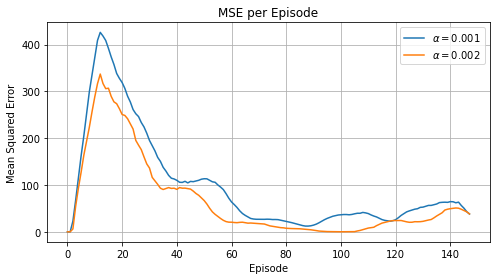

In [11]:
from scipy.ndimage import uniform_filter

mse_per_episode_avg1 = uniform_filter(mse_per_episode_tot1, size=10)
mse_per_episode_avg2 = uniform_filter(mse_per_episode_tot2, size=10)

# MSE vs. Episode
plt.figure(figsize=(7, 4))
plt.plot(mse_per_episode_avg1[0:len(reward_hist_tot1)], label=alph1)
plt.plot(mse_per_episode_avg2[0:len(reward_hist_tot1)], label=alph2)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title('MSE per Episode')
plt.legend()
plt.grid(True)
# plt.ylim(0, 100)
plt.tight_layout()
plt.show()

> **TODO:** Plot batch loss per epoch

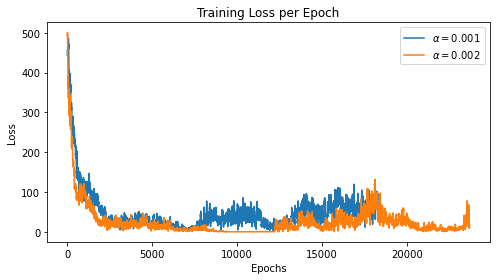

In [12]:
#TODO

> **TODO:** Plot training time, and wall-clock time per episode.

## State histogram

> **TODO:** Test the agents by plotting their state histogram for 20 episodes.

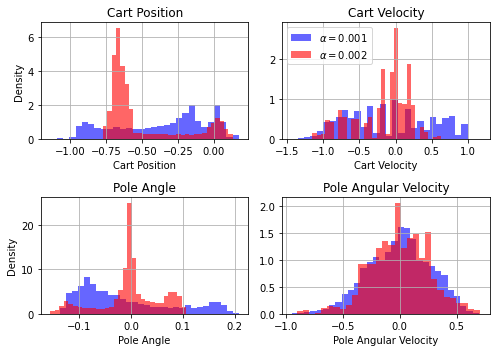

In [14]:
# TODO